## Land Cover example

For this example we will use a portion of the National Land Cover Dataset (2011), available at:  
(may not extract correctly on a Mac)
http://gisdata.usgs.gov/tdds/downloadfile.php?TYPE=nlcd2011_lc_3x3&ORIG=SBDDG&FNAME=NLCD2011_LC_N42W090.zip  

metadata available at:
https://www.sciencebase.gov/catalog/file/get/550c31ebe4b02e76d759d4cf?f=__disk__c0%2F5f%2F03%2Fc05f0303de240ee865a9dafd2a653b7c21c29feb&transform=1&allowOpen=true

In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import box
import rasterio
from rasterio.tools.mask import mask
import matplotlib.pyplot as plt
from GISops import clip_raster, project_raster
from GISio import shp2df

% matplotlib inline

### Clip the original raster down to a smaller area encompassing La Crosse County
(this doesn't need to be run if `data/NLCD2011.tif` already exists)

In [2]:
"""
project_raster('data/NLCD2011_LC_N42W090/NLCD2011_LC_N42W090.tif', 
               'data/NLCD2011_full.tif', dst_crs='EPSG:4269', resampling=0)
bbox = box(-91.5, 43.7, -90.9, 44.2)
clip_raster('data/NLCD2011_full.tif', [bbox], 'data/NLCD2011.tif')
"""

"\nproject_raster('data/NLCD2011_LC_N42W090/NLCD2011_LC_N42W090.tif', \n               'data/NLCD2011_full.tif', dst_crs='EPSG:4269', resampling=0)\nbbox = box(-91.5, 43.7, -90.9, 44.2)\nclip_raster('data/NLCD2011_full.tif', [bbox], 'data/NLCD2011.tif')\n"

### Read in land cover raster and mask with county


reading data/counties.shp...
--> building dataframe... (may take a while for large shapefiles)


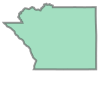

In [3]:
counties = shp2df('data/counties.shp')
lac = counties.geometry[0]
lac

In [4]:
with rasterio.open('data/NLCD2011.tif') as src:
    # apply the mask using the geoJSON representation of La Crosse County
    out_image, out_transform = mask(src, [lac.__geo_interface__], nodata=0, crop=True)
    out_meta = src.meta.copy()

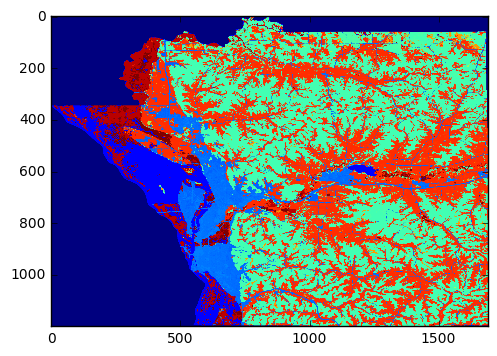

In [5]:
plt.imshow(out_image[0])

### Use `numpy.bincount` to count number of occurances of discrete values
* `np.bincount` returns an array of instance counts for values 0 through the maximum value in the input array  
(lenght `np.amax(input_array) + 1`
* input array must be 1D

In [6]:
bincnt = np.bincount(out_image.ravel())
bincnt

array([530535,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,  94401,      0,      0,      0,      0,
            0,      0,      0,      0,      0,  50151,  63227,  33922,
        10203,      0,      0,      0,      0,      0,      0,    593,
            0,      0,      0,      0,      0,      0,      0,      0,
            0, 585194,  21494,   5433,      0,      0,      0,      0,
            0,      0,      0,      0,   8715,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  14093,
            0,      0,      0,      0,      0,      0,      0,      0,
            0, 123187, 398584,      0,      0,      0,      0,      0,
            0,      0,  61996,      0,      0,      0,      0,  26272])

### make a sparse dictionary of these

In [7]:
counts = dict(zip(range(len(bincnt)), bincnt))
counts = {k:v for k, v in counts.items() if v > 0}
counts

{0: 530535,
 11: 94401,
 21: 50151,
 22: 63227,
 23: 33922,
 24: 10203,
 31: 593,
 41: 585194,
 42: 21494,
 43: 5433,
 52: 8715,
 71: 14093,
 81: 123187,
 82: 398584,
 90: 61996,
 95: 26272}

In [8]:
categories = {11: 'Open Water',
 21: 'Developed, Open Space',
 22: 'Developed, Low Intensity',
 23: 'Developed, Medium Intensity',
 24: 'Developed, High Intensity',
 31: 'Barren Land',
 41: 'Decidous Forest',
 42: 'Evergreen Forest',
 43: 'Mixed Forest',
 52: 'Shrub/Scrub',
 71: 'Grassland/Herbaceous',
 81: 'Pasture/Hay',
 82: 'Cultivated Crops',
 90: 'Woody Wetlands',
 95: 'Emergent Herbaceous Wetlands'}

### Assign the labels

In [9]:
ncells = out_image[out_image > 0].size
fractions = {}
for k, v in counts.items():
    if k > 0:
        frac = 100 * v/ncells
        fractions[categories[k]] = frac

### convert to `pandas.DataFrame` and sort

In [10]:
df = pd.DataFrame([fractions]).T.reset_index()
df.columns = ['Category', 'Percent']
df.sort_values(by='Percent', inplace=True, ascending=False)
df

,Category,Percent
2,Decidous Forest,39.078977
1,Cultivated Crops,26.617250
12,Pasture/Hay,8.226369
11,Open Water,6.304054
4,"Developed, Low Intensity",4.222269
14,Woody Wetlands,4.140063
6,"Developed, Open Space",3.349060
5,"Developed, Medium Intensity",2.265295
7,Emergent Herbaceous Wetlands,1.754432
8,Evergreen Forest,1.435359


#### save results to csv file

In [11]:
df.to_csv('LaCrosseCo_LC.csv', index=False)